<a href="https://colab.research.google.com/github/frtrigg5/A-new-signature-model/blob/main/DatasetGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EXAMPLE OF DATASET: FBM PROBLEM**

In [1]:
import fbm
import numpy as np
from lib.data.synthetic import MB_sample

In [14]:
#construction of the dataset
d = 1 # dimension of the timeseries
begin = 0 # first timestep
end = 1 # last timestep
number = 100 # length of each timeseries
trShape, vlShape, testShape = 1000, 400, 600
H = 0.26 # Hurst exponent
f = fbm.FBM(number - 1, H)

known_times = np.linspace(begin, end, number) #istanti temporali noti
div = 1 # quanti nuovi istanti temporali prendere tra due istanti noti
new_times = np.zeros(div*(number - 1))
for i in range(0, (number-1)):
  new_times[(div*i):(div*(i+1))] = np.linspace(known_times[i], known_times[i+1], (div+2))[1:(1+div)]

L1 = known_times.size
L2 = new_times.size

timestamps = np.concatenate((known_times, new_times), axis=0)
# time series train
dataset_value = np.zeros(shape=[trShape, number])
for i in range(0, 500):
  dataset_value[i] = MB_sample(begin, end, number)[0]
  dataset_value[i+500] = f.fbm()

# time series validation
dataset_value2 = np.zeros(shape=[vlShape, number])
for i in range(0, 200):
  dataset_value2[i] = MB_sample(begin, end, number)[0]
  dataset_value2[i+200] = f.fbm()

# time series test
dataset_value3 = np.zeros(shape=[testShape, number])
for i in range(0, 300):
  dataset_value3[i] = MB_sample(begin, end, number)[0]
  dataset_value3[i+300] = f.fbm()
 
# adding Known and unknown time stamps
time_data = np.zeros((trShape, L1 + L2))
for i in range(0, trShape):
  time_data[i] = timestamps

time_data2 = np.zeros((vlShape, L1 + L2))
for i in range(0, vlShape):
  time_data2[i] = timestamps

time_data3 = np.zeros((testShape, L1 + L2))
for i in range(0, testShape):
  time_data3[i] = timestamps  

#full dataset train
dataset = np.concatenate((time_data, dataset_value), axis=-1) #full dataset
dataset = dataset.astype('float32')

#full dataset validation
dataset2 = np.concatenate((time_data2,dataset_value2), axis=-1) #full dataset
dataset2 = dataset2.astype('float32')

#full dataset test
dataset3 = np.concatenate((time_data3, dataset_value3), axis=-1) #full dataset
dataset3 = dataset3.astype('float32')

#label construction
y = np.zeros((trShape, 1), dtype='uint8') #label o for Brownian Motion, 1 for FBM
y[500:] = np.ones((500, 1), dtype='uint8') 

#label di validation
y2 = np.zeros((vlShape, 1), dtype='uint8')
y2[200:] = np.ones((200,1), dtype='uint8') 

#label di test
y3 = np.zeros((testShape,1), dtype='uint8') 
y3[300:] = np.ones((300,1), dtype='uint8') 

In [15]:
import torch
from lib.dataset import MyDataset

batch = 60
training_data = MyDataset(y, dataset)
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch, shuffle=True)

validation_data = MyDataset(y2, dataset2)
validation_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=vlShape, shuffle=False)

In [19]:
sample, label = training_data.__getitem__(0)
sample_known_times, sample_new_times, path = sample[:L1], sample[L1:(L1+L2)], sample[(L1+L2):]

assert np.allclose(known_times, sample_known_times)
assert np.allclose(new_times, sample_new_times)

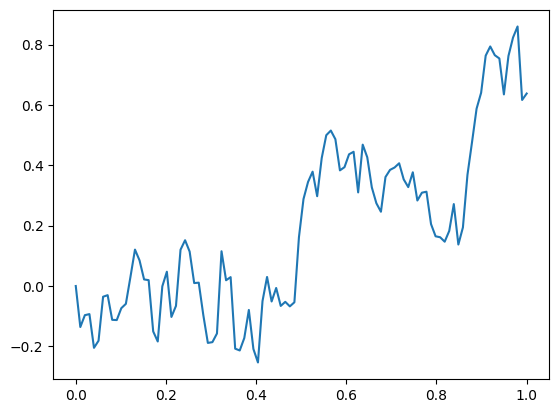

In [23]:
import matplotlib.pyplot as plt

plt.plot(known_times, path)
plt.show()